<font color=blue>Students names and IDs: </font>

### Exercise overview
In this exercise, we will continue to work with the data from exercise 9. For the detailed context of the data, I refer you to the previous exercise. In exercise 9, we extracted 30 features from our epoched local field potential data recorded from epileptic mice, and we used these feature for unsupervised learning to detect seizure activity. Here we will see how Principal Component Analysis and Independent Component Analysis can be useful tools in the digital signal processing toolbox, when working with (bio)medical signals.

In this relatively short exercise, we have three relatively simple objectives.
1. We  will use Independent Component Analysis (ICA) to try to extract muscle artifacts from our signals.
2. We will use Principal Component Analysis (PCA) for dimensionality reduction on the features computed in the previous exercise.
3. We will use K-means clustering using a few principal components as our features.

Code will be provided for parts of the exercise that are a repeat of the previous exercise and are referred to as *STEPS* in the following. Parts that you will have to solve are referred to as *TASKS*. There are 3 *TASKS* matching with the objectives listed above.

### Required modules
During this practical session the following libraries will be used:
- [__Numpy__](https://docs.scipy.org/doc/numpy-dev/user/quickstart.html): library used for scientific computing containing N-dimensional arrays, functions and Fourier transform.
- [__Matplotlib__](https://matplotlib.org/users/pyplot_tutorial.html): plotting library used for the visualization of data from python.
- [__scipy__](https://docs.scipy.org/doc/scipy/getting_started.html): scientific library contaning many useful functions for signal manipulation and statistics
- [__scikit-learn__](https://scikit-learn.org/stable/getting_started.html): open source machine learning library that supports supervised and unsupervised learning

In [1]:
# import statements
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from scipy.fft import fft
from scipy.signal import find_peaks, detrend, hann
from scipy.stats import pearsonr
from sklearn.decomposition import FastICA
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix

%matplotlib inline
#%matplotlib widget

#Use %matplotlib inline instead of %matplotlib widget when preparing the final report. 
#Otherwise the images are, unfortunately, not embedded in the pdf. 

In [2]:
# load data
data = np.load('lfp.npy')
print(np.shape(data))

(4800000, 3)


<div class="alert alert-info">

### STEP 1. Preprocessing (filtering, time domain epoching)
**CODE PROVIDED**
    
A 2nd order butterworth bandpass filter between 1 and 500 Hz is design and implemented with the the filtfilt function. Note that this essentially applies the filter twice, making it a 4th order filter).

In [3]:
# bandpass filtering

def butter_bandpass(lowcut, highcut, fs, order=2):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='bandpass')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=2):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

fs = 2000
ts = 1/fs
length_data = np.shape(data)[0] / fs # length in seconds
lowcut = 1
highcut = 500
n_chans = 3

for i in range(n_chans):    
    data[:,i] = butter_bandpass_filter(data[:,i], 1, 500, fs, order=2)

<div class="alert alert-info">
    
### TASK 1: Independent Component Analysis
The data provided are electrophysiologcal recordings from the brain of epileptic mice. However, these signals will be contaminated to a certain extent by activity of surrounding facial muscles involved in chewing behavior of the animal. In the following, we will apply ICA to the time domain signals in an attempt to remove muscle artifacts which clearly have a different source than the brain activity we are interested in (muscle vs. brain).

Do the following:  
1. Use the *FastICA* algorithm of the *sklearn.decomposition* libary (imported provided). Use *random_state=0* and set *n_components=3*. Normally ICA generates components in random order, but by setting *random_state=0*, we will all get the same order of components, where the first component will reflect the muscle activity, which was most prominent in channel 3. (Cell 1)
2. Plot the independent components generated as a function of time using the template plotting code provided. (Cell 2)
3. Remove the muscle artefact component by setting it to 0 and perform an inverse transform to go back to sensor space. You can look up the documentation on how to do this. Call the variable with the restored data *'restored_data'*. (Cell 3)
4. Visualize the impact of removing this component from the data on the respective channels, using the template plotting code provided. Here we will focus on a specific segment, which nicely visualizes what removing this component does to the data. (Cell 4)
5. Oberserve how removing the muscle artifact component first and foremost affects channel 3, but also how muscle artifacts are reduced in amplitude the other channels. At this point, however, channel 3 does not add anything to our data and you should remove it from the *data* variable that will be used for computing features in the following parts of the exercise. (Cell 5)

In [4]:
## Cell 1: Code for ICA
ica = FastICA(n_components=3,random_state=0,whiten='unit-variance')
data_transformed = ica.fit_transform(data)

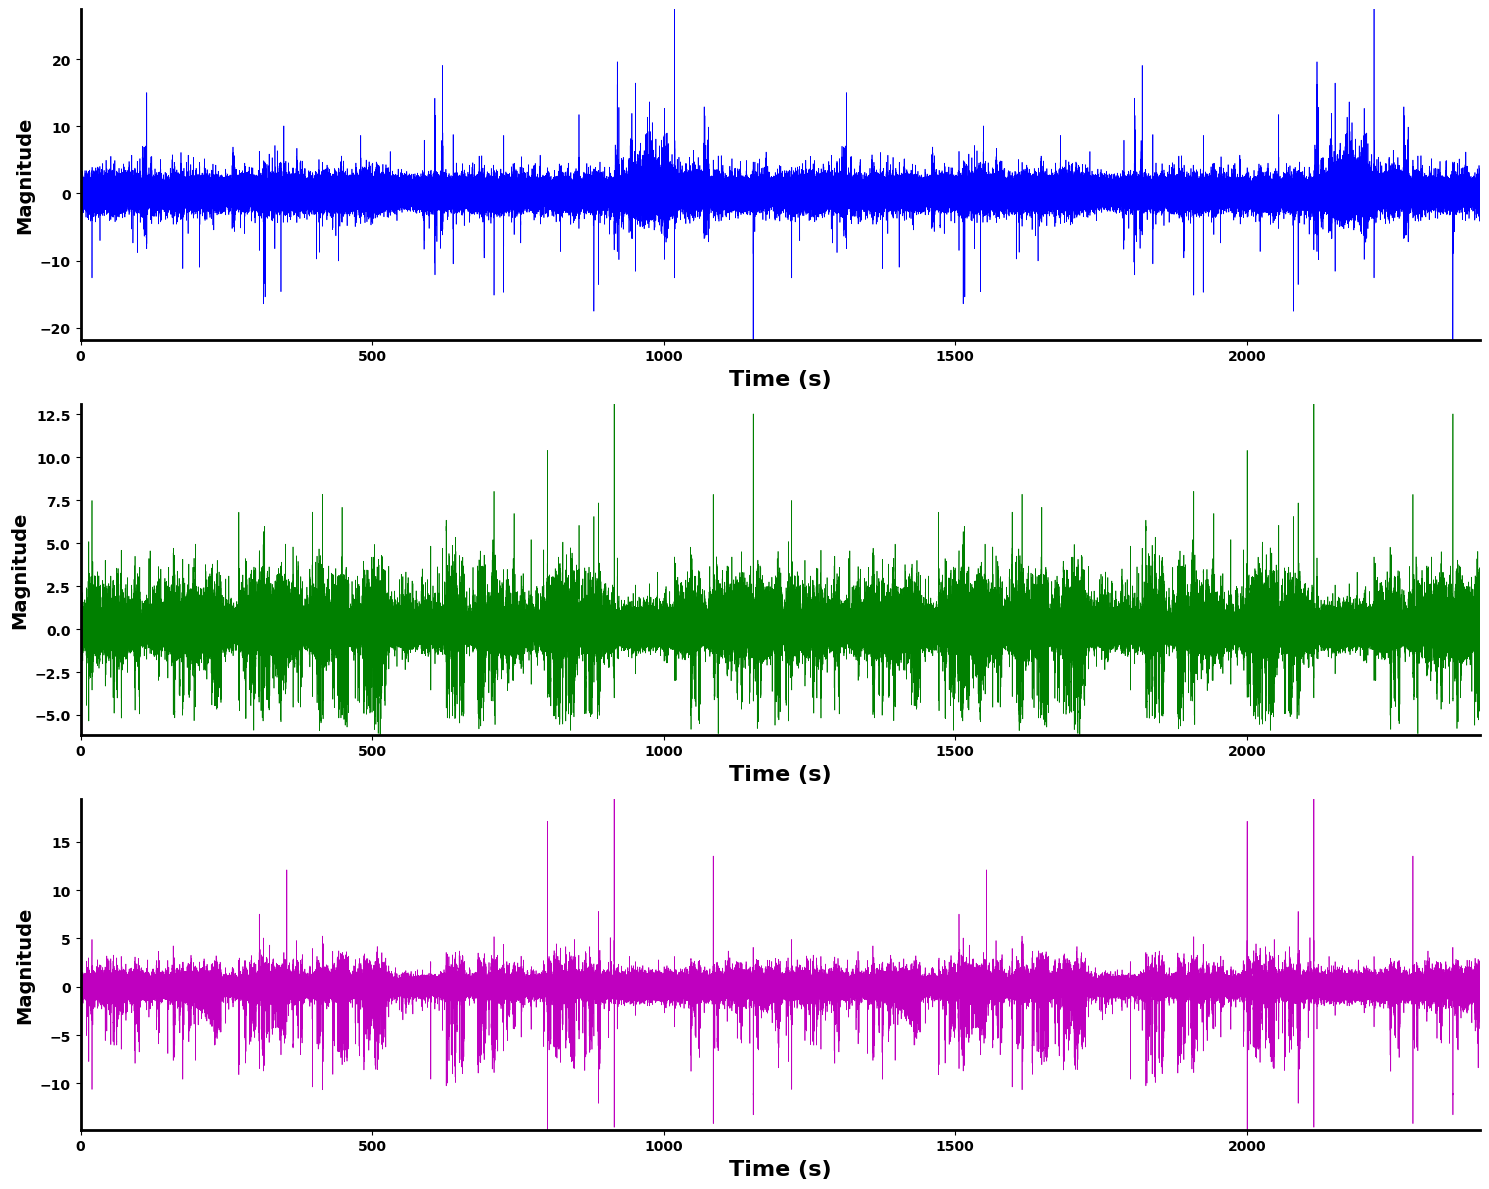

In [5]:
## Cell 2: Plot the independent components
N, n_chans = data.shape 
t = np.linspace(0,2400,N)

ics = data_transformed
ic1,ic2,ic3 = data_transformed[:,0],data_transformed[:,1],data_transformed[:,2]


plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
fig, ax = plt.subplots(3, figsize=(15,12))

ax[0].plot(t, ic1, linewidth=0.5, color = 'b') # provide t,ic1 for function
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].spines['bottom'].set_linewidth(2)
ax[0].spines['left'].set_linewidth(2)
ax[0].set_ylabel('Magnitude', fontsize=14, fontweight='bold')
ax[0].set_xlabel('Time (s)', fontsize=16, fontweight='bold')
ax[0].set_xlim(0, 2400)
ax[0].set_ylim(np.min(ics[:,0]), np.max(ics[:,0]))

ax[1].plot(t, ic2, linewidth=0.5, color = 'g') # provide t,ic2 for function
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].spines['bottom'].set_linewidth(2)
ax[1].spines['left'].set_linewidth(2)
ax[1].set_ylabel('Magnitude', fontsize=14, fontweight='bold')
ax[1].set_xlabel('Time (s)', fontsize=16, fontweight='bold')
ax[1].set_xlim(0, 2400)
ax[1].set_ylim(np.min(ics[:,1]), np.max(ics[:,1]))

ax[2].plot(t, ic3, linewidth=0.5, color = 'm') # provide t,ic3 for function
ax[2].spines['top'].set_visible(False)
ax[2].spines['right'].set_visible(False)
ax[2].spines['bottom'].set_linewidth(2)
ax[2].spines['left'].set_linewidth(2)
ax[2].set_ylabel('Magnitude', fontsize=14, fontweight='bold')
ax[2].set_xlabel('Time (s)', fontsize=16, fontweight='bold')
ax[2].set_xlim(0, 2400)
ax[2].set_ylim(np.min(ics[:,2]), np.max(ics[:,2]))
plt.tight_layout()


In [6]:
# Cell 3: Set first independent component to 0, and perform and inverse transform to get back to source space
# Call the variable with the restored data 'restored_data'
ics[:,0] = np.zeros_like(ic1)
data_restored = ica.inverse_transform(ics)

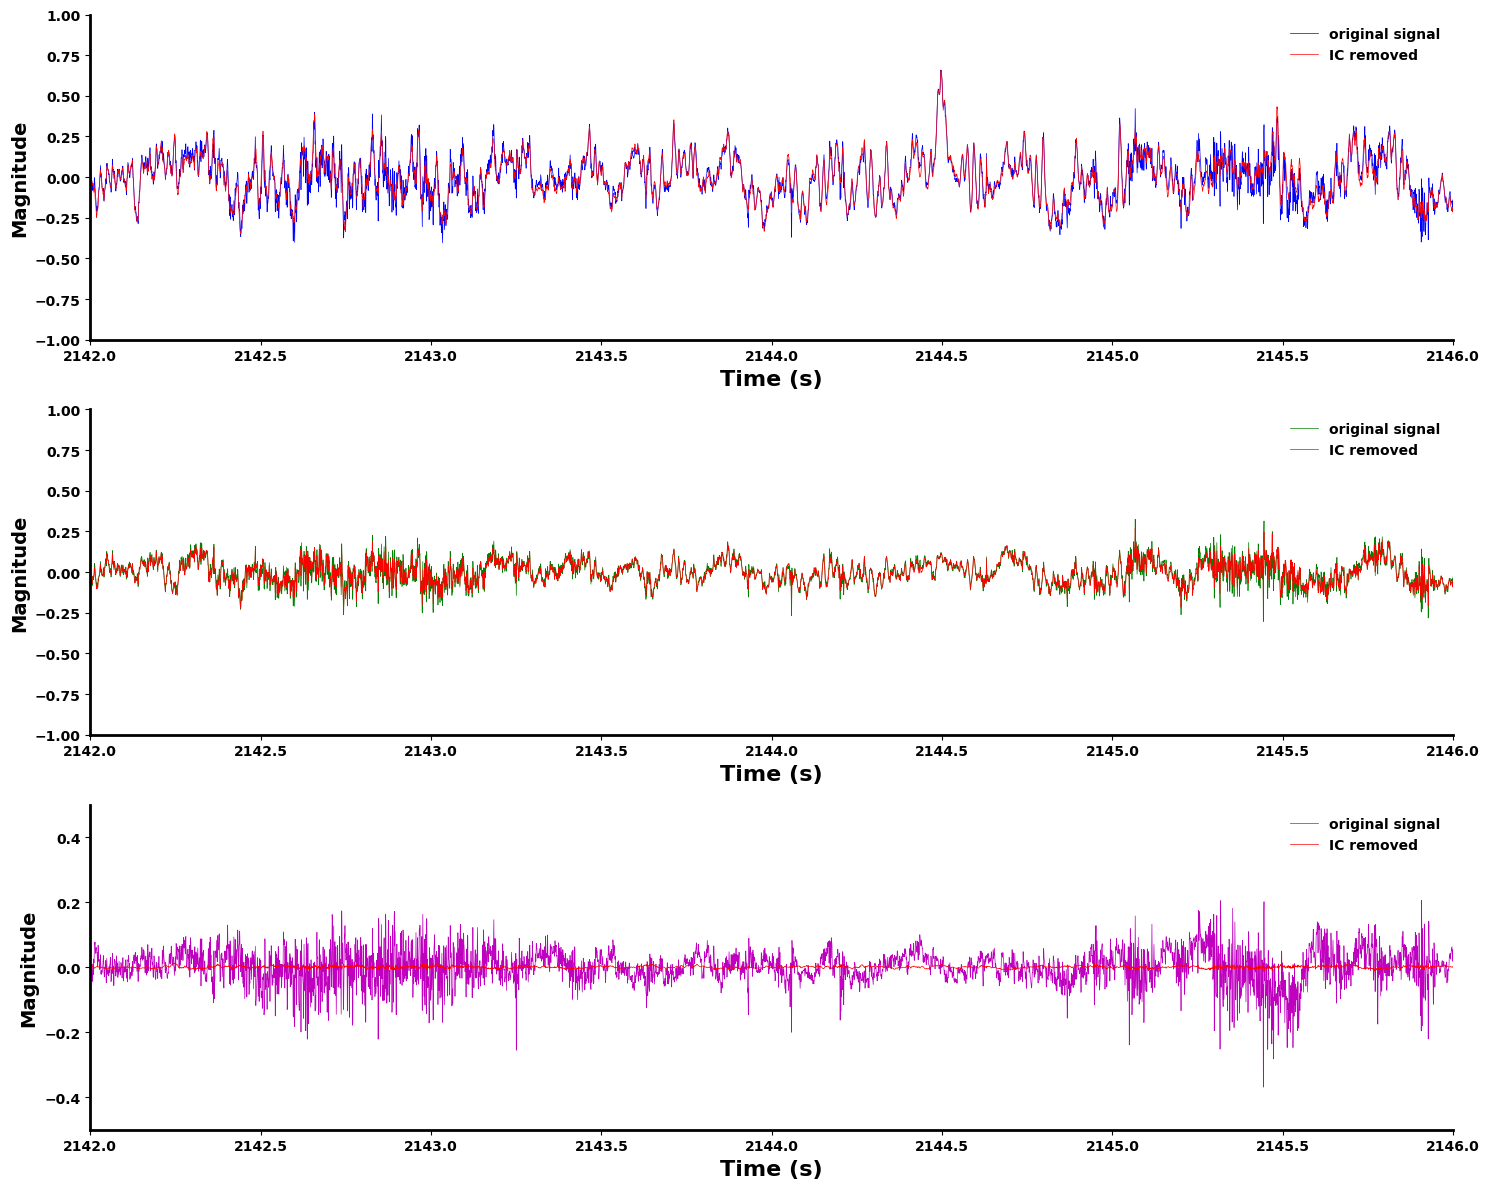

In [7]:
# Cell 4: Plot the original signal vs. the signals after removal of the first independent component
# we focus on the time segment between 2142 and 2146 seconds.

fs = 2000

plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
fig, ax = plt.subplots(3, figsize=(15,12))

# provide t, data and restored data bellow
ax[0].plot(t[int(fs*2142):int(fs*2146)], data[int(fs*2142):int(fs*2146),0], linewidth=0.5, color = 'b', label='original signal') # provide t,y for function
ax[0].plot(t[int(fs*2142):int(fs*2146)], data_restored[int(fs*2142):int(fs*2146),0], linewidth=0.5, color = 'r', label='IC removed') # provide t,y for function
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].spines['bottom'].set_linewidth(2)
ax[0].spines['left'].set_linewidth(2)
ax[0].set_ylabel('Magnitude', fontsize=14, fontweight='bold')
ax[0].set_xlabel('Time (s)', fontsize=16, fontweight='bold')
ax[0].set_xlim(2142, 2146)
ax[0].set_ylim(-1,1)
ax[0].legend(frameon=False)

# provide t, data and restored data bellow
ax[1].plot(t[int(fs*2142):int(fs*2146)], data[int(fs*2142):int(fs*2146),1], linewidth=0.5, color = 'g', label='original signal') # provide t,y for function
ax[1].plot(t[int(fs*2142):int(fs*2146)], data_restored[int(fs*2142):int(fs*2146),1], linewidth=0.5, color = 'r', label='IC removed') # provide t,y for function
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].spines['bottom'].set_linewidth(2)
ax[1].spines['left'].set_linewidth(2)
ax[1].set_ylabel('Magnitude', fontsize=14, fontweight='bold')
ax[1].set_xlabel('Time (s)', fontsize=16, fontweight='bold')
ax[1].set_xlim(2142, 2146)
ax[1].set_ylim(-1,1)
ax[1].legend(frameon=False)

# provide t, data and restored data bellow
ax[2].plot(t[int(fs*2142):int(fs*2146)], data[int(fs*2142):int(fs*2146),2], linewidth=0.5, color = 'm', label='original signal') # provide t,y for function
ax[2].plot(t[int(fs*2142):int(fs*2146)], data_restored[int(fs*2142):int(fs*2146),2], linewidth=0.5, color = 'r', label='IC removed') # provide t,y for function
ax[2].spines['top'].set_visible(False)
ax[2].spines['right'].set_visible(False)
ax[2].spines['bottom'].set_linewidth(2)
ax[2].spines['left'].set_linewidth(2)
ax[2].set_ylabel('Magnitude', fontsize=14, fontweight='bold')
ax[2].set_xlabel('Time (s)', fontsize=16, fontweight='bold')
ax[2].set_xlim(2142, 2146)
ax[2].set_ylim(-0.5,0.5)
ax[2].legend(frameon=False)
plt.tight_layout()


In [8]:
# Cell 5: Remove the third channel from the restored data
data = data_restored[:,:2]
print(data.shape)

(4800000, 2)


<div class="alert alert-info">
    
### STEP 2. Feature computation
    
**CODE PROVIDED**

The following features are computed:
1. Delta power (sum of power in the 1-4 Hz band)
2. Theta power (sum of power in the 5-10 Hz band)
3. Alpha power (sum of power in the 11-16 Hz band)
4. Beta power (sum of power in the 16-30 Hz band)
5. Low gamma power (sum of power in the 30-100 Hz band)
6. High gamma power (sum of power in the 100-500 Hz band)
7. Standard deviation in time domain
8. Number of negative spikes (peaks) exeeding a threshold of 3 standard deviations
9. Number of postive spikes (peaks) exeeding a threshold of 3 standard deviations
10. Amplitude correlation between all combinations of channel pairs
    
Since we have reduced the number of channels to 2, we will now only have 19 features vs. the 30 in the previous exercise.

In [9]:
# epoching and feature computations on the time domain and frequency domain epochs

fs = 2000
epoch_size = 1*fs
n_chans = 2 # after removing 3rd channel
overlap = 0.5 # percentage overlap
n_epochs = int((np.shape(data)[0] / epoch_size) / (1-overlap) - 1) # number of epochs

# time domain epoching
lfp_epochs = np.zeros((epoch_size, n_chans, n_epochs))
for i in range(n_epochs):
    start = int((i * epoch_size) * (1 - overlap))
    stop = int(start + epoch_size)
    for j in range(n_chans):
        lfp_epochs[:,j,i] = detrend(data_restored[start:stop,j]) # leave time domain epoching

# FFT on epochs
window = hann(epoch_size)
fft_lfp_epochs = np.zeros((epoch_size, n_chans, n_epochs))
for i in range(n_epochs):
    for k in range(n_chans):
        x = lfp_epochs[:, k, i] * window
        X = np.abs(fft(x)) ** 2
        fft_lfp_epochs[:, k, i] = X

fft_lfp_epochs = fft_lfp_epochs[0:int(len(X)/2+1),:,:] # 

# feature computation
f1_delta_power = 10*np.log10(np.squeeze(np.sum(fft_lfp_epochs[1:5,:,:], axis=0)))
f2_theta_power = 10*np.log10(np.squeeze(np.sum(fft_lfp_epochs[5:11,:,:], axis=0)))
f3_alpha_power = 10*np.log10(np.squeeze(np.sum(fft_lfp_epochs[11:17,:,:], axis=0)))
f4_beta_power = 10*np.log10(np.squeeze(np.sum(fft_lfp_epochs[17:31,:,:], axis=0)))
f5_lowgamma_power = 10*np.log10(np.squeeze(np.sum(fft_lfp_epochs[31:101,:,:], axis=0)))
f6_highgamma_power = 10*np.log10(np.squeeze(np.sum(fft_lfp_epochs[101:,:,:], axis=0)))
f7_std = np.squeeze(np.std(lfp_epochs, axis=0))

f8_negativepeaks = np.zeros((n_chans, n_epochs))
f9_positivepeaks = np.zeros((n_chans, n_epochs))
std_signal = np.std(data, axis=0)
for i in range(n_epochs):
    for k in range(n_chans):
        f8_negativepeaks[k, i] = len(find_peaks(lfp_epochs[:,k,i]*-1, height=3 * std_signal[k], distance=fs*0.1)[0])
        f9_positivepeaks[k, i] = len(find_peaks(lfp_epochs[:,k,i], height=3 * std_signal[k], distance=fs*0.1)[0])

f10_correlations = np.zeros((n_epochs))
for i in range(n_epochs):
    f10_correlations[i] = pearsonr(lfp_epochs[:,0,i], lfp_epochs[:,1,i])[0] ** 2

<div class="alert alert-info"> 
    
### STEP 3. Feature arrangement and normalization
**CODE PROVIDED**


    
Features are arranged in a $M x N$ matrix, where each column represents a particular feature and each row gives you the value of the features per epoch. Subsequently, a z-score statistical normalization to each of the 19 features:

$$
    z = \dfrac{{x - \mu}}{{\sigma}}
$$
<br>
Here $x$ is each instance of your feature, $\mu$ is the average and $\sigma$ is the standard deviation. Feature normalization is an important step prior to principal component analysis.

In [10]:
feature_matrix = np.row_stack((f1_delta_power,
                               f2_theta_power,
                               f3_alpha_power,
                               f4_beta_power,
                               f5_lowgamma_power,
                               f6_highgamma_power,
                               f7_std,
                               f8_negativepeaks,
                               f9_positivepeaks,
                               f10_correlations))

feature_matrix = feature_matrix.T
z_feature_matrix = np.zeros((np.shape(feature_matrix)[0], np.shape(feature_matrix)[1]))
for i in range(np.shape(feature_matrix)[1]):
    mean = np.mean(feature_matrix[:,i], axis=0)
    std = np.std(feature_matrix[:,i], axis=0)
    
    z_feature_matrix[:,i] = (feature_matrix[:,i] - mean) / std

print(np.shape(z_feature_matrix))

(4799, 19)


<div class="alert alert-info"> 

### TASK 2: Principal Component Analysis
Now that 19 features have been computed, it is time to use PCA with the aim to reduce dimensionality even further. In other words, many of the computed features are likely to be correlated and it is therefore likely that a large part of the variability of these features can be explain be a few principal components, which are weighted sums of the features. 
    
1. Apply PCA to the z-normalized feature data matrix computed above. You can use the PCA algorithm of the *sklearn.decomposition* library to do this. Please get an overview of the documentation before you apply this algorithm. (Cell 1)
2. Next, plot the variance explained per principal components as well as the cumulative explained variance of the components. We can again use the *elbow-method* to select a suitable number of principal components to keep. (Cell 2)

In [15]:
# Cell 1: Code for PCA
n_components = 19
pca = PCA(n_components=19,random_state=0)
pca.fit(z_feature_matrix)
variance = pca.explained_variance_ratio_*100

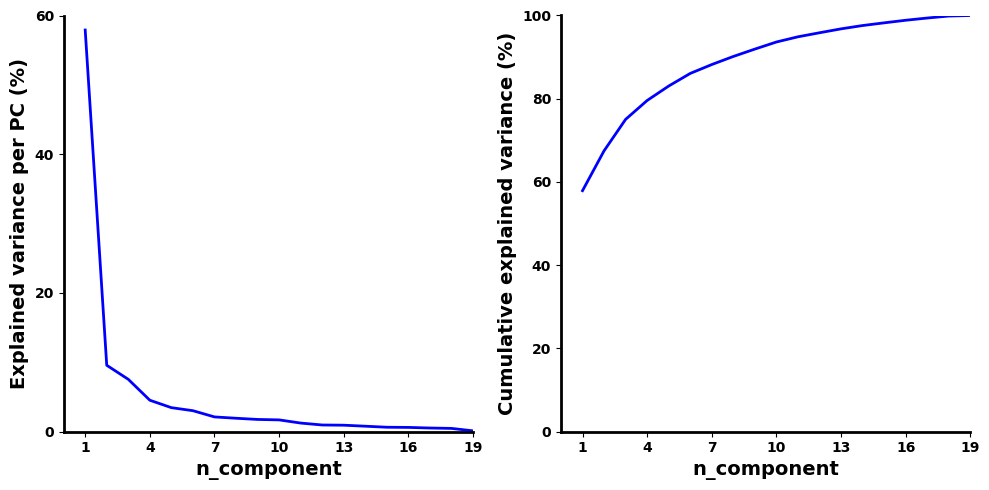

In [16]:
# Cell 2: Plot explained variance of principal components, use template code below
# Remember to convert explained variance into % (i.e x 100)
component_number = np.array([i for i in range(1,20)])
cum_sum = [np.sum(variance[:i]) for i in range(1,20)]

plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

# provide the plotting variables below
ax[0].plot(component_number, variance, linewidth=2, color = 'b') # provide t,y for function
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].spines['bottom'].set_linewidth(2)
ax[0].spines['left'].set_linewidth(2)
ax[0].set_xticks([1, 4, 7, 10, 13, 16, 19])
ax[0].set_xticklabels([1, 4, 7, 10, 13, 16, 19])
ax[0].set_yticks([0, 20, 40, 60])
ax[0].set_yticklabels([0, 20, 40, 60])
ax[0].set_ylabel('Explained variance per PC (%)', fontsize=14, fontweight='bold')
ax[0].set_xlabel('n_component', fontsize=14, fontweight='bold')
ax[0].set_xlim(0, n_components)
ax[0].set_ylim(0, 60)

# provide the plotting variables below
ax[1].plot(component_number, cum_sum, linewidth=2, color = 'b') # provide t,y for function
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].spines['bottom'].set_linewidth(2)
ax[1].spines['left'].set_linewidth(2)
ax[1].set_xticks([1, 4, 7, 10, 13, 16, 19])
ax[1].set_xticklabels([1, 4, 7, 10, 13, 16, 19])
ax[1].set_yticks([0, 20, 40, 60, 80, 100])
ax[1].set_yticklabels([0, 20, 40, 60, 80, 100])
ax[1].set_ylabel('Cumulative explained variance (%)', fontsize=14, fontweight='bold')
ax[1].set_xlabel('n_component', fontsize=14, fontweight='bold')
ax[1].set_xlim(0, n_components)
ax[1].set_ylim(0, 100)

plt.tight_layout()

<div class="alert alert-info"> 

### Task 3: K-means clustering with principal components as features

1. First we will apply the principal component transformation to our z-scored feature matrix. (Cell 1)
2. We will then perform K-means clustering in principal component space. Initially, we will do this with a variable with a variable number of clusters to then use the elbow method*. As you will see, we now indeed have a clear *elbow* at two clusters. (Cell 2)
3. Perform a final K-means cluster analysis with K=2. (Cell 3)
4. We will then visualize these clusters in principal component space, which is one of the advantages that dimensionality reduction has. We will do so with pairwise principal component plots and use the labels our data With this visualization, it should become clear to you that we have managed to apply appropriate transformations to our data that has allowed us to perform some seperation of data points. (Cell 4)

In [21]:
# Cell 1: PCA transformation of z-scored data matrix - call this variable 'pcs'
# select the first 4 principal components
pcs = pca.fit_transform(z_feature_matrix)[:,:4]

d:\Documenten\Github\Ugent\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
d:\Documenten\Github\Ugent\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
d:\Documenten\Github\Ugent\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
d:\Documenten\Github\Ugent\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
d:\Documenten\Github\Uge

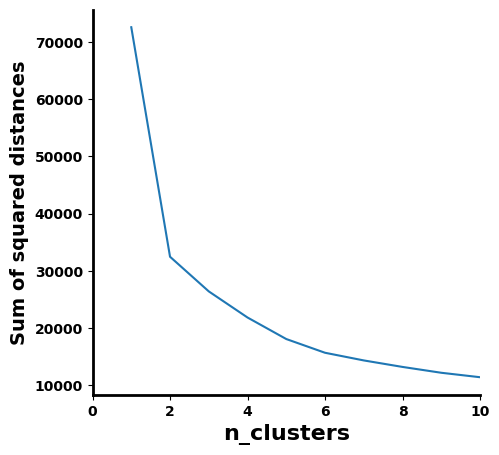

In [22]:
# Cell 2: K-means clustering with variable number of clusters + elbow plot
distortions = np.zeros(10)
for i in range(1,11):
    model = KMeans(i,random_state=0).fit(pcs)
    distortions[i-1] = model.inertia_
    
## plot spectrograms
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
fig, ax = plt.subplots(1, figsize=(5,5))

#provide distortions below for elbow plot
ax.plot(range(1,11), distortions)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.set_ylabel('Sum of squared distances', fontsize=14, fontweight='bold')
ax.set_xlabel('n_clusters', fontsize=16, fontweight='bold')
ax.set_xlim(0, 10)
#ax.set_ylim(1,1000)
plt.show()

In [23]:
# Cell 3: K-means clustering with K=2, random_state = 0
kmeans = KMeans(2,random_state=0).fit(pcs)

d:\Documenten\Github\Ugent\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


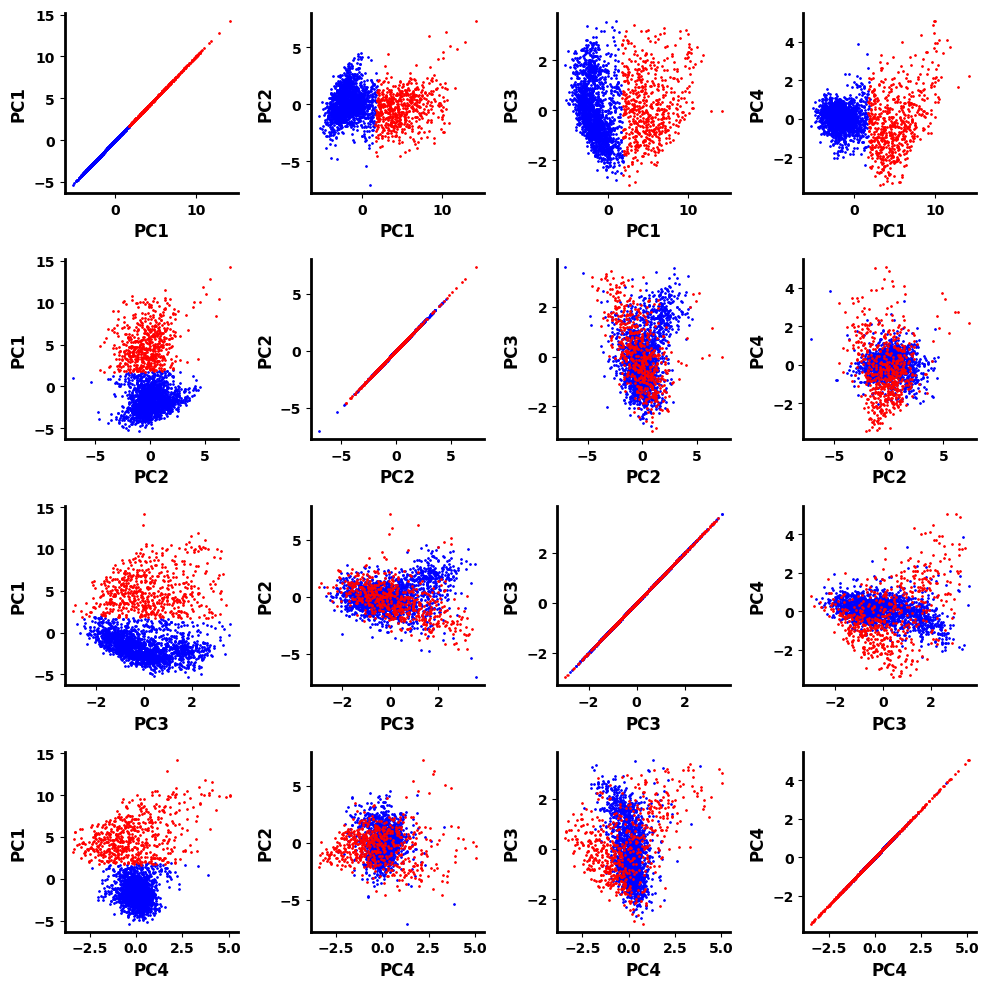

In [24]:
# Cell 4: Visualization of clusters in principal component space


labels = kmeans.labels_ # extract the labels from your kmeans model made in cell 3

plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(10,10))

for row in range(4):
    for col in range(4):
        # provide the 'pcs' variable containing your pc transformed z-transformed data matrix
        ax[row, col].scatter(pcs[labels==0, row], pcs[labels==0,col], color = 'b', s=0.5) # provide t,y for function
        ax[row, col].scatter(pcs[labels==1, row], pcs[labels==1,col], color = 'r', s=0.5) # provide t,y for function
        ax[row, col].spines['top'].set_visible(False)
        ax[row, col].spines['right'].set_visible(False)
        ax[row, col].spines['bottom'].set_linewidth(2)
        ax[row, col].spines['left'].set_linewidth(2)
        ax[row, col].set_xlabel('PC' + str(row+1), fontsize=12, fontweight='bold')
        ax[row, col].set_ylabel('PC' + str(col+1), fontsize=12, fontweight='bold')
        
        #ax.set_xlim(0, n_components)
        #ax.set_ylim(0, 60)

plt.tight_layout()


<div class="alert alert-info"> 

### Step 5: Visualization of final cluster results in time domain
**CODE PROVIDED**

We have identified two clear clusters in principal component space, which are particularly clear when we look at PC1 vs. PC2, and PC1 vs. PC4. The initial aim of exercise 9 and 10 was to evaluate how unsupervised classification maybe useful to seperate healthy brain activity from disease related (epileptic) brain activity.
    
Below we will overlay the labels generated by the K-means cluster analysis with the time domain signals of channel 1 and visualize these at different time scales. Red shading means that label 1 has been assigned to the epoch, which we recognize as seizure activity.

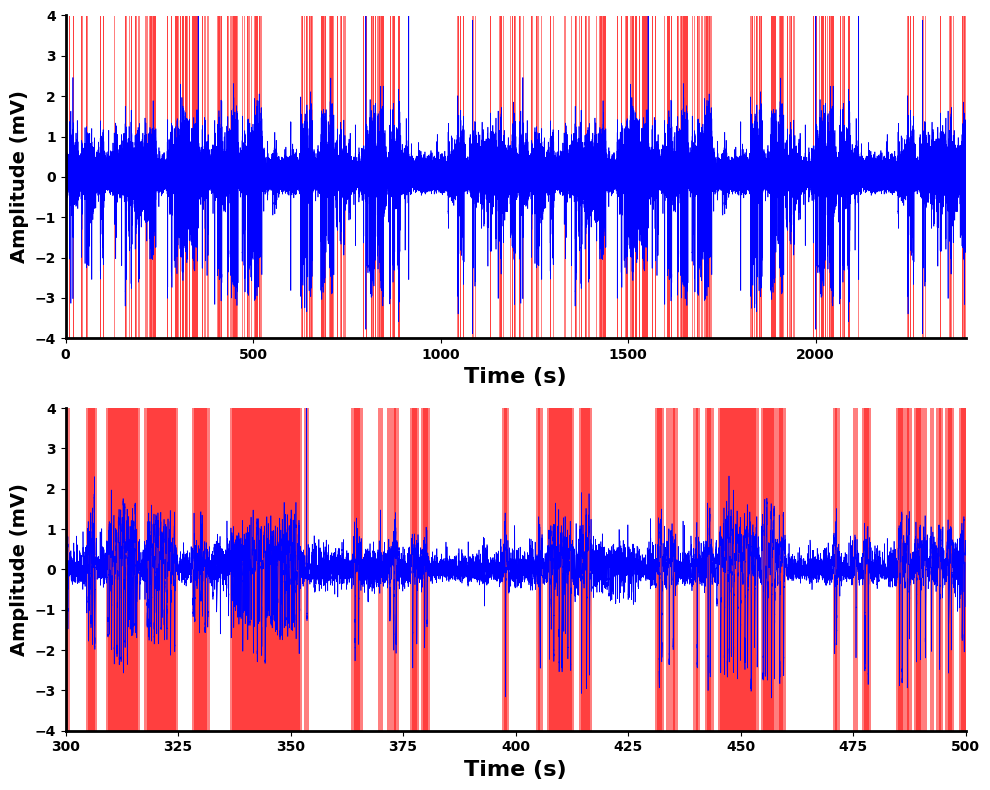

In [25]:
# Cell 1: visualization of cluster results in time domain

labels = labels # recalling the labels generated by the K-means cluster analysis

t_epochs = np.arange(0.5, 2400, 0.5) # time vector

## plot time domain
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
fig, ax = plt.subplots(2, figsize=(10,8))

ax[0].plot(t, data[:,0], linewidth=0.5, color = 'b')
for i in range(len(labels)):
    if labels[i]==1:
        ax[0].axvspan(xmin=t_epochs[i]-0.5, xmax=t_epochs[i]+0.5, ymin=-4, ymax=4, facecolor='r', alpha=0.5)
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].spines['bottom'].set_linewidth(2)
ax[0].spines['left'].set_linewidth(2)
ax[0].set_ylabel('Amplitude (mV)', fontsize=14, fontweight='bold')
ax[0].set_xlabel('Time (s)', fontsize=16, fontweight='bold')
ax[0].set_xlim(0, 2400)
ax[0].set_ylim(-4, 4)

ax[1].plot(t, data[:,0], linewidth=0.5, color = 'b')
for i in range(len(labels)):
    if labels[i]==1:
        ax[1].axvspan(xmin=t_epochs[i]-0.5, xmax=t_epochs[i]+0.5, ymin=-4, ymax=4, facecolor='r', alpha=0.5)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].spines['bottom'].set_linewidth(2)
ax[1].spines['left'].set_linewidth(2)
ax[1].set_ylabel('Amplitude (mV)', fontsize=14, fontweight='bold')
ax[1].set_xlabel('Time (s)', fontsize=16, fontweight='bold')
ax[1].set_xlim(300, 500)
ax[1].set_ylim(-4, 4)

plt.tight_layout()

<div class="alert alert-info"> 
    
### Step 6: Evaluation of final cluster results in time domain
**CODE PROVIDED**    

We have identified two clear clusters in principal component space, which are particularly clear when we look at PC1 vs. PC2, and PC1 vs. PC4. The initial aim of exercise 9 and 10 was to evaluate how unsupervised classification maybe useful to seperate healthy brain activity from disease related (epileptic) brain activity.
    
Below we will overlay the labels generated by the K-means cluster analysis with the time domain signals of channel 1 and 2

In [26]:

manual_annotations = np.load('annotations.npy') 

seizure_starts = manual_annotations[:,0]
seizure_ends = manual_annotations[:,1]
labels_ints = (manual_annotations * 2000).astype(int)
binary_labels = np.zeros((len(data)))

for i in range(len(seizure_starts)):
    binary_labels[labels_ints[i,0]:labels_ints[i,1]] = 1

annotations = np.zeros((n_epochs))
for i in range(n_epochs):
    start = int((i * epoch_size) * (1 - overlap))
    stop = int(start + epoch_size)
    percent = np.mean(binary_labels[start:stop])
    if percent >= .5:
        annotations[i] = 1   

labels[labels==2]=0

(tn, fp), (fn, tp) = confusion_matrix(annotations, labels)

tpr = tp/(tp+fn) # sensitivity
ppv = tp/(tp+fp) # specificity
f1 = (2 * tp) / (2 * tp + fp + fn)

print(tpr)
print(ppv)
print(f1)

0.6393117140966248
0.8284734133790738
0.7217033993276055


<div class="alert alert-success">
<span style="color:black">

### Concluding statements (provided)
We have learned how ICA and PCA are useful tools in the process of reducing the complexity of multidimensional data.
1.  ICA was in this case used for blind source seperation, which allowed us to reduce the amplitude and impact of muscle artefacts on the data we were interested in (brain).
2. We saw how multidimensional data can be explained by a few principal components, without losing too much information. PCA allowed us to reduce the number of features, allowing us to visualize our data in two-dimensional plots and without losing performance in our K-means clustering analysis. 
    
The constructed algorithm is clearly seperating seizures (marked in red above) from normal healthy brain activity and is doing so with impresive accuracy. Although the labels do not match perfect with the manual annotations, it is important to understand that unsupervised classifiers are purely data based, which means that it looks at the data as it is and classifies accordingly. The manual labels provided, however, are subject to human error, and arbitrary human definitions (i.e. no seizures shorted than ~5 seconds have been labeled). The classifier, however, will label everything that looks like seizure activity.